In [13]:
%pylab inline

import pandas as pd
from scipy.linalg import hankel, svd, pinv, inv

import scipy.linalg as LA

Populating the interactive namespace from numpy and matplotlib


In [3]:
#data

data = array([ 391.54788285,  389.7249173 ,  402.79749586,  409.40396389,
        421.41442439,  454.72998201,  663.2059145 ,  685.36737838,
        779.46751955,  816.61048881,  811.20931519,  726.01863819,
        679.90767767,  795.08615631,  742.11109049,  769.83279499,
        686.02182736,  487.28423186,  403.86948873,  408.74254241,
        338.42417135,  333.39510729,  318.0165695 ,  346.49627497,
        435.8738527 ,  564.73871386,  591.98231172,  556.11552783,
        711.50455072,  659.60534338,  666.62782932,  742.66363333,
        746.58028554,  700.2348443 ,  733.59405276,  708.35510896,
        590.48395073,  654.09359168,  476.00003581,  441.24445147,
        359.58450425,  337.32937411])

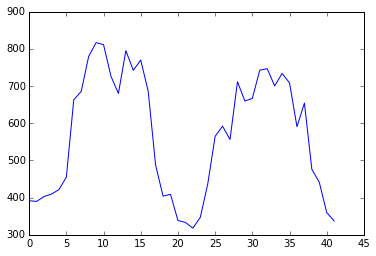

In [5]:
plot(data)

In [12]:
def LPSVD(signal, M = None, lfactor = 1/2, removebias = True):
	'''
	A function that performs the linear prediction-singular value decomposition
	of a signal that is assumed to be a linear combination of damped sinusoids

	signal : ndarray
		The signal to be analyzed
	M : int
		Model order, if None, it will be estimated
	lfactor : float
		How to size the Hankel matrix, Tufts and Kumaresan suggest 1/3-1/2
		Default number of prediction coefficients is half the number of points in the input wave
	removebias	: bool
		If true bias will be removed from the singular values of A

	'''

	if lfactor > 3/4:
		print("You attempted to use an lfactor greater than 3/4, it has been set to 3/4")
		lfactor=3/4

	N = len(signal)	#length of signal
	L = int(np.floor(N*lfactor))	#Sizing of the Hankel matrix, i.e. the backward prediction matrix

	rollsig = np.roll(signal,-1)					#Shift the signal forward by 1
	A = hankel(rollsig[:N-L],signal[L:])	#Generate the Hankel matrix

	A = np.conj(A)		#Take the conjugate of the Hankel Matrix to form the prediction matrix

	h = signal[:N-L]	#Set up the data vector, the vector to be "predicted"
	h = np.conj(h)		#Take the conjugate

	U, S, VT = svd(A)	#Perform an SVD on the Hankel Matrix

	#We can estimate the model order if the user hasn't selected one
	if M is None:
		M  = estimate_model_order(S,N,L)+8
		print("Estimated model order: {}".format(M))


	if M > len(S):
		M = len(S)
		print("M too large, set to max = ".format(M))

	#remove bias if needed
	if removebias:
		#Here we subtract the arithmatic mean of the singular values determined to be
		#noise from the rest of the singular values as described in Barkhuijsen
		S -= S[M:].mean()

	S = 1/S[:M]	#invert S and truncate

	#Redimension the matrices to speed up the matrix multiplication step
	VT = VT[:M,:]	#Make VT the "right" size
	U = U[:,:M]		#Make U the "right" size

	#Now we can generate the LP coefficients
	lp_coefs = -1*np.conj(VT.T).dot(np.diag(S)).dot(np.conj(U.T)).dot(h)

	#Error check: are there any NaNs or INFs in lp_coefs?
	if not np.isfinite(lp_coefs).all():
		raise ValueError("There has been an error generating the prediction-error filter polynomial")

	#Need to add 1 to the beginning of lp_coefs before taking roots
	lp_coefs = np.insert(lp_coefs,0,1)

	#I can now find the roots of B (assuming B represents the coefficients of a polynomial)
	#Note that NumPy defines polynomial coefficients with the larges power first
	#so we have to reverse the coefficients before finding the roots.
	myroots = np.roots(lp_coefs[::-1])

	#Remove the poles that lie within the unit circle on the complex plane as directed by Kurmaresan
	#Actually it seems the correct thing to do is to remove roots with positive damping constants
	usedroots = np.array([np.conj(np.log(root)) for root in myroots if np.abs(root) <= 1])

	#Error checking: see if we removed all roots!
	if len(usedroots) == 0:
		raise ValueError("There has been an error finding the real poles")

	#sort by freqs
	usedroots = usedroots[np.imag(usedroots).argsort()]
	#Lets make a DataFrame with dimension labels to store all our parameters
	LPSVD_coefs = pd.DataFrame(columns = ['amps','freqs','damps','phase'])

	#We can directly convert our poles into estimated damping factors and frequencies
	LPSVD_coefs.damps = np.real(usedroots)
	LPSVD_coefs.freqs = np.imag(usedroots)/(2*np.pi)

	#But we need to do a little more work to get the predicted amplitudes and phases
	#Here we generate our basis matrix
	basis = np.array([np.exp(np.arange(len(signal))*root) for root in usedroots])

	#Take the inverse
	pinvBasis = pinv(basis)

	#And apply it to our signal to recover our predicted amplitudes
	#Amps here are complex meaning it has amplitude and phase information
	cAmps = pinvBasis.T.dot(signal)

	LPSVD_coefs.amps = np.abs(cAmps)
	LPSVD_coefs.phase = np.angle(cAmps)

	#Calculate the errors
	#calc_LPSVD_error(LPSVD_coefs,signal)

	return LPSVD_coefs#, Errors

def estimate_model_order(s,N,L):
    '''
    Adapted from from Complex Exponential Analysis by Greg Reynolds
    http://www.mathworks.com/matlabcentral/fileexchange/12439-complex-exponential-analysis/
    Use the MDL method as in Lin (1997) to compute the model
    order for the signal. You must pass the vector of
    singular values, i.e. the result of svd(T) and
    N and L. This method is best explained by Scharf (1992).

    Parameters
    ----------
    s : ndarray
        singular values from SVD decomposition
    N : int
    L : int

    Returns
    -------
    M : float
        Estimated model order
    '''
    MDL = np.zeros(L)
    
    for i in range(L):
        MDL[i] = -N*np.log(s[i:L]).sum()
        MDL[i] += N*(L-i)*np.log(s[i:L].sum()/(L-i))
        MDL[i] += i*(2*L-i)*np.log(N)/2;

    return MDL.argmin()

def reconstruct_signal(LPSVD_coefs, signal ,ampcutoff = 0, freqcutoff = 0, dampcutoff = 0):
    '''
    #A function that reconstructs the original signal in the time domain and frequency domain
    #from the LPSVD algorithms coefficients, which are passed as LPSVD_coefs
    #http://mathworld.wolfram.com/FourierTransformLorentzianFunction.html

    WAVE LPSVD_coefs		#coefficients from the LPSVD algorithm
    String name				#Name of the generated waves
    Variable length			#Length of the time domain signal
    Variable timeStep		#Sampling frequency with which the signal was recorded, in fs
    Variable dataReal		#Should the output time domain data be real?
    Variable ampcutoff		#Cutoff for the amplitudes of the components
    Variable freqcutoff		#Cutoff for the frequency of the components
    Variable dampcutoff		#Cutoff for the damping of the components
    '''

    #Initialize time domain signal
    time_domain = np.zeros_like(signal,dtype=complex)
    p = np.arange(len(signal))

    for i, row in LPSVD_coefs.iterrows():
        damp = -row.damps/np.pi
        if row.amps**2 > ampcutoff and damp >= dampcutoff:
            #Keep in mind that LPSVD_coefs were constructed agnostic to the actual sampling
            #frequency so we will reconstruct it in the same way
            amp = row.amps
            damp = row.damps
            phase = row.phase
            freq = row.freqs
            time_domain += amp*np.exp(p*complex(damp,2*np.pi*freq)+complex(0,1)*phase)

    if signal.dtype != complex:
        time_domain = np.real(time_domain)

    return time_domain

In [14]:
LPSVD(data)

Estimated model order: 11


,amps,freqs,damps,phase
0,128.361320,-0.048476,-0.009019,-2.885091e+00
1,615.543182,-0.000000,-0.003321,-1.836796e-16
2,128.361320,0.048476,-0.009019,2.885091e+00
